In [1]:
import numpy as np
import pandas as pd
import math
import logging
from msig import Motif, NullModel
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, MSTL
import matplotlib.pylab as pylab
import matplotlib.dates as mdates

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 20}
pylab.rcParams.update(params)


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [3]:
#read csv
data = pd.read_csv('../data/populationdensity/hourly_taz.csv', parse_dates=['one_time'], date_format='%Y-%m-%d %H:%M:%S')
#taz_id to taz_name dict
taz_id_name = {}
for taz_id in data['taz_id'].unique():
    taz_name = data[data['taz_id'] == taz_id]['taz_name'].values[0]
    taz_id_name[taz_id] = taz_name

#remove taz_name == 'Unknown' and 'Other'
data = data[data['taz_name'] != 'Beato (Picheleira)']
data = data[data['taz_name'] != 'Alcântara (Ribeirinha - Belém)']

data

,taz_id,taz_name,one_time,sum_terminals,sum_roaming_terminals,sum_terminals_with_active_data,sum_roaming_terminals_with_active_data,sum_phonecalls,sum_ended_phonecalls,avg_upstream_bandwidth,avg_downstream_bandwidth,min_avg_downstream_bandwidth,min_avg_upstream_bandwidth,max_upstream_bandwidth,max_downstream_bandwidth,sum_sum_terminals_sharing,wkt_taz
0,69,Areeiro (Alto Pina),2021-11-26 09:00:00,61599.0,1131.0,58113.0,1107.0,2896.0,574.0,7524.772105,101178.976512,104.328000,105.621997,39330404.0,135947840.0,0.00,POLYGON ((-9.131441060130475 38.74471703960398...
1,70,Arroios (Estefânia),2021-11-26 09:00:00,145078.0,4477.0,138532.0,4351.0,5149.0,1178.0,7678.938176,53412.218959,2752.320035,14550.430893,63988960.0,405100896.0,12.43,POLYGON ((-9.144729944918017 38.73514419538672...
2,71,Arroios (Arroios | Norte),2021-11-26 09:00:00,31194.0,945.0,29608.0,920.0,1284.0,420.0,5017.655536,58454.086946,943.014966,842.953344,3146271.0,142608816.0,0.00,POLYGON ((-9.136504202275457 38.73689574768296...
3,53,Alvalade (Campo Grande),2021-11-26 09:00:00,51055.0,864.0,48474.0,849.0,1520.0,474.0,8951.088582,70079.739010,2236.359946,17768.382601,33589812.0,96555216.0,0.00,"POLYGON ((-9.15660999782037 38.7593274576093, ..."
4,40,Lumiar (Telheiras | Oeste),2021-11-26 09:00:00,40523.0,255.0,37014.0,252.0,2314.0,382.0,3442.786203,32570.243025,1.238571,0.000000,16425652.0,168218912.0,0.00,"POLYGON ((-9.17712280774748 38.76422000124379,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175218,16,Estrela (Estrela),2021-11-26 09:00:00,199615.0,6739.0,190222.0,6497.0,7990.0,1839.0,10347.174511,75677.619332,573.914546,628.886265,67788656.0,566004672.0,0.00,"POLYGON ((-9.16455004654274 38.71408737534585,..."
175219,12,Ajuda (Ajuda | Norte),2021-11-26 09:00:00,27901.0,487.0,25890.0,481.0,1100.0,342.0,199281.838168,236425.820611,0.000000,0.000000,130461056.0,152884192.0,0.00,POLYGON ((-9.194104152143993 38.72438283212201...
175220,15,Estrela (Lapa),2021-11-26 09:00:00,9932.0,432.0,9298.0,429.0,605.0,154.0,3801.634144,39603.158490,1.328000,0.000000,1539097.0,67348640.0,0.00,POLYGON ((-9.167543700000001 38.70657329999994...
175221,13,Estrela (Ribeirinha - Belém),2021-11-26 09:00:00,6586.0,138.0,6119.0,138.0,410.0,77.0,2781.907062,16101.249632,0.000000,0.000000,11564562.0,18501752.0,0.00,POLYGON ((-9.161911000000002 38.70242249999994...


In [5]:
features = ["sum_terminals"]
stats_table = pd.DataFrame()
resids = {}
#for each taz_id
for taz_id in data['taz_id'].unique():
    #get the data for that taz_id
    taz_data = data[data['taz_id'] == taz_id]
    taz_data = taz_data.drop(columns=['taz_name'])
    taz_data["datetime"] = pd.to_datetime(taz_data["one_time"])
    taz_data = taz_data.drop(columns=['one_time', "taz_id", "wkt_taz"])
    taz_data.set_index('datetime', inplace=True) 
    for data_feature in features:
        time_serie = taz_data[[data_feature]].asfreq('h')
        if np.all(time_serie == 0):
            continue
        res = MSTL(np.squeeze(time_serie), periods=[24,24*7]).fit()
        resids[str(taz_id)+"_"+data_feature] = res.resid

        var_resid = np.var(res.resid)
        var_observed = np.var(res.observed)
        trend_strength = max(0, 1 - (var_resid/np.var(res.trend+res.resid)))
        noise_strength = var_resid/var_observed

        seasonal_individial_strengths = {}
        for period in res.seasonal:
            seasonal_individial_strengths["F_"+str(period)] = max(0, 1 - (var_resid/np.var(res.seasonal[period] + res.resid)))
        seasonal_strength = max(0, 1 - (var_resid/np.var(res.seasonal.sum(axis=1) + res.resid)))


        stats_df = {"id": taz_id, "Feature": data_feature,
                    "F_T": round(trend_strength, 3),
                    "F_S": round(seasonal_strength, 3), "F_R": round(noise_strength, 3)}
            
        #add individual seasonal strengths to stats_df, rounded with 3 decimals
        for period in seasonal_individial_strengths:
            stats_df[period] = round(seasonal_individial_strengths[period], 3)
                
        stats_table = pd.concat([stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True)
        
stats_table

,id,Feature,F_T,F_S,F_R,F_seasonal_24,F_seasonal_168
0,69,sum_terminals,0.448,0.426,0.391,0.260,0.278
1,70,sum_terminals,0.325,0.822,0.164,0.749,0.620
2,71,sum_terminals,0.373,0.564,0.346,0.404,0.380
3,53,sum_terminals,0.336,0.862,0.129,0.811,0.652
4,40,sum_terminals,0.595,0.454,0.307,0.325,0.262
...,...,...,...,...,...,...,...
96,89,sum_terminals,0.158,0.893,0.105,0.885,0.447
97,95,sum_terminals,0.045,0.727,0.273,0.561,0.587
98,101,sum_terminals,0.158,0.744,0.247,0.634,0.550
99,39,sum_terminals,0.327,0.697,0.259,0.532,0.528


In [6]:
stats_table = stats_table.sort_values(by=['F_R'], ascending=False)
#save the table
stats_table.to_csv('../results/populationdensity/hourly_taz_decomposition_summary.csv', index=False)
#get the name from the taz id
stats_table['Name'] = stats_table['id'].apply(lambda x: taz_id_name[x])
stats_table


,id,Feature,F_T,F_S,F_R,F_seasonal_24,F_seasonal_168,Name
5,37,sum_terminals,0.059,0.404,0.574,0.267,0.236,São Domingos de Benfica (Estrada Luz | Oeste)
7,41,sum_terminals,0.057,0.554,0.434,0.414,0.351,Lumiar (Telheiras | Este)
64,77,sum_terminals,0.352,0.445,0.425,0.319,0.252,Penha de França (Penha França)
57,72,sum_terminals,0.293,0.510,0.406,0.378,0.305,Arroios (Arroios | Sul)
36,83,sum_terminals,0.366,0.470,0.403,0.328,0.282,Marvila (Chelas)
...,...,...,...,...,...,...,...,...
82,100,sum_terminals,0.371,0.878,0.113,0.845,0.632,Parque das Nações (Estação Oriente)
63,74,sum_terminals,0.672,0.862,0.108,0.837,0.522,Santa Maria Maior (Baixa)
96,89,sum_terminals,0.158,0.893,0.105,0.885,0.447,Lumiar (Aeroporto)
67,29,sum_terminals,0.863,0.732,0.102,0.649,0.458,São Domingos de Benfica (Sete Rios | Norte)


In [7]:
#to latex first 5 rows with name, trend, seasonals and noise
print(stats_table[['Name', 'F_T', 'F_seasonal_24', 'F_seasonal_168', 'F_R']].head(5).to_latex())

\begin{tabular}{llrrrr}
\toprule
 & Name & F_T & F_seasonal_24 & F_seasonal_168 & F_R \\
\midrule
5 & São Domingos de Benfica (Estrada Luz | Oeste) & 0.059000 & 0.267000 & 0.236000 & 0.574000 \\
7 & Lumiar (Telheiras | Este) & 0.057000 & 0.414000 & 0.351000 & 0.434000 \\
64 & Penha de França (Penha França) & 0.352000 & 0.319000 & 0.252000 & 0.425000 \\
57 & Arroios (Arroios | Sul) & 0.293000 & 0.378000 & 0.305000 & 0.406000 \\
36 & Marvila (Chelas) & 0.366000 & 0.328000 & 0.282000 & 0.403000 \\
\bottomrule
\end{tabular}



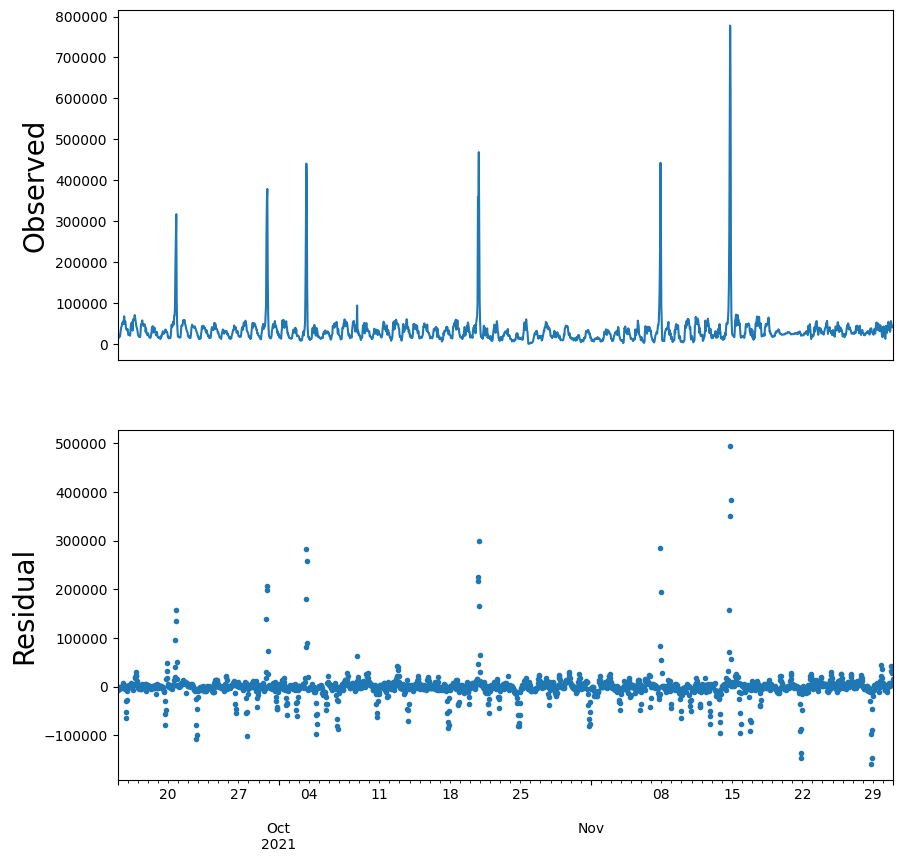

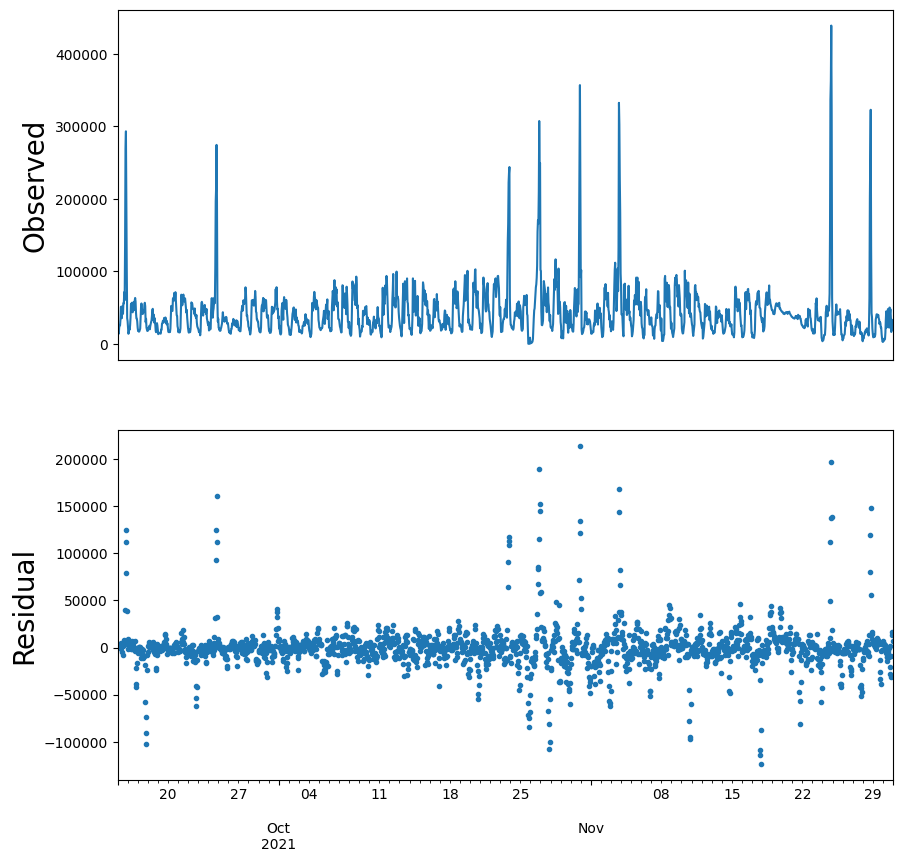

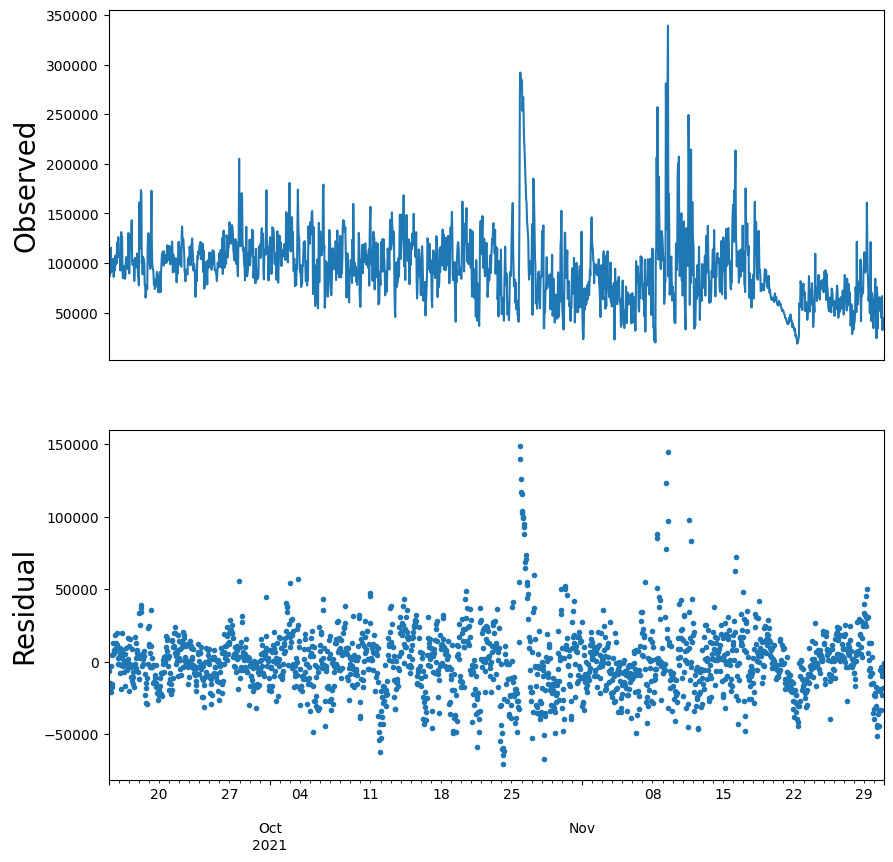

In [8]:
#plot the data and residuals of top 3 taz_ids
top_taz_ids = stats_table['id'].head(3).values
#create dataframe with taz_id and resids
top_resids = pd.DataFrame()
for taz_id in top_taz_ids:
    for data_feature in features:
        #add to dataframe, id, data feature and resids
        observed = data[data['taz_id'] == taz_id][[data_feature, "one_time"]].sort_values(by='one_time').set_index('one_time')
        index = observed.index.values
        row = {"id": taz_id, "feature": data_feature,"index":index, "observed": observed.T.values[0],"residuals": resids[str(taz_id)+"_"+data_feature]}
        top_resids = pd.concat([top_resids, pd.DataFrame(row)], ignore_index=True)


#for (id, feature) get dataframe and plot observed and residuals
for i, df in top_resids.groupby(by=["id","feature"]):
    #plot observed and residuals
    fig, axes = plt.subplots(figsize=(10,10), ncols=1, nrows=2, sharex=True)
    observed = pd.DataFrame(df['observed'].values, index=df['index'])
    resid = pd.DataFrame(df['residuals'].values, index=df['index'])   
    observed.plot(ax=axes[0], legend=False,  label="",xlabel="", ylabel="Observed")
    resid.plot(ax=axes[1], style=".", legend=False,xlabel="", ylabel="Residual")
    axes[0].axes.get_xaxis().set_visible(False)
    plt.show()


    


In [9]:
#motif discovery
import stumpy

# discover motifs
normalize = True
subsequence_lengths = [6,12,24]

In [10]:
for m in subsequence_lengths:
    for i, df in top_resids.groupby(by=["id","feature"]):
        X = np.squeeze(df['residuals'].values)
        out = stumpy.stump(X, m, normalize=normalize)
        np.save('../results/populationdensity/mp/hourly_taz_normalized={}_m={}_{}_{}.npy'.format(normalize,m,i[0],i[1]), out, allow_pickle=True)


In [13]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))

def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time-m)/np.ceil(m/2)+1))

        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]

        #minmax normalize subsequence
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (max_values - min_values)
        ce_norm_subsequence = multivar_subsequence_complexity(normalized_multivar_subsequence)
        norm_ce_norm_subsequence = ce_norm_subsequence/(np.sqrt(len(multivar_subsequence[0])-1)*len(dimensions))

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = 
            max_allowed_dist = max(np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)]), epsilon)
        
        unified_weights = "0.33,0.33,0.33"
        excl_zone = np.ceil(m/4)
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = w1*(1-(med_dist/max_allowed_dist)) + w2*(len(match_indices)/max_possible_matches) + w3*norm_ce_norm_subsequence

        #remove timepoints from time series in match all indices + m
        time_series_nomatches = data[dimension].copy()
        #list of indexes to remove
        indexes_to_remove = [i for index in match_indices for i in range(index, index + m)]
        #put zero in the indexes to remove
        time_series_nomatches[indexes_to_remove] = 0

        #calculate variance explained by the motif
        variance_explained = 100 * (1 - (np.var(time_series_nomatches) / np.var(data[dimension])))

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        #max_delta = max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)

        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "CE": np.around(norm_ce_norm_subsequence,3), "Score Unified": np.around(unified,3),
                        "Explained Var(%)": np.around(variance_explained,2),
                        "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.DataFrame.from_records([stats_df]) if mp_stats_table.empty else pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [14]:
k = None
min_neighbors = 1
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for i, df in top_resids.groupby(by=["id","feature"]):
    for m in subsequence_lengths:
            X = np.squeeze(df['residuals'].values)
            mp = np.load('../results/populationdensity/mp/hourly_taz_normalized=True_m={}_{}_{}.npy'.format(m,i[0],i[1]), allow_pickle=True)
            motif_distances, motif_indices  = stumpy.motifs(X, mp[:, 0], max_distance=max_distance,max_matches=max_matches,
                                                                                    cutoff=cutoff, min_neighbors=min_neighbors, max_motifs=max_motifs, normalize=normalize)
            if len(motif_indices[0]) == 0:
                continue
            print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
            # to work with table_summary_motifs which expects multidimensional motifs
            motif_subspaces = [np.array([0])]*len(motif_indices)
            X = np.array([X])
            table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
            print("Sig ", np.sum(table["p-value"] < 0.01))
            #hochberg procedure
            p_values = table["p-value"].to_numpy()
            critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
            sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
            table["Sig_Hochber"] = sig

            print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))
            mp_stats_table = table if mp_stats_table.empty else pd.concat([mp_stats_table, table], ignore_index=True)

    mp_stats_table.to_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]), index=False)

INFO:root:p_value = 1.403E-51 (p_pattern = 2.086E-03)


m:6, #Motifs:41


/tmp/ipykernel_1834/4060642926.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 1.274E-16 (p_pattern = 8.369E-03)
INFO:root:p_value = 2.684E-58 (p_pattern = 2.391E-03)
INFO:root:p_value = 5.330E-148 (p_pattern = 5.511E-06)
INFO:root:p_value = 9.792E-79 (p_pattern = 1.151E-04)
INFO:root:p_value = 1.000E+00 (p_pattern = 1.258E-01)
INFO:root:p_value = 4.664E-132 (p_pattern = 3.013E-05)
INFO:root:p_value = 2.844E-76 (p_pattern = 9.312E-05)
INFO:root:p_value = 9.947E-01 (p_pattern = 1.211E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 1.604E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.652E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 4.109E-01)
INFO:root:p_value = 4.995E-08 (p_pattern 

Sig  16
Sig after Hochberg: 15, critical value: 1.38758294606945e-05
m:12, #Motifs:30


/tmp/ipykernel_1834/4060642926.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 1.583E-153 (p_pattern = 1.652E-05)
INFO:root:p_value = 1.201E-104 (p_pattern = 9.605E-05)
INFO:root:p_value = 2.723E-85 (p_pattern = 7.966E-05)
INFO:root:p_value = 1.650E-112 (p_pattern = 5.964E-05)
INFO:root:p_value = 6.663E-145 (p_pattern = 1.935E-06)
INFO:root:p_value = 8.837E-19 (p_pattern = 2.128E-02)
INFO:root:p_value = 1.267E-129 (p_pattern = 1.666E-05)
INFO:root:p_value = 1.763E-104 (p_pattern = 1.097E-03)
INFO:root:p_value = 1.000E+00 (p_pattern = 4.618E-01)
INFO:root:p_value = 1.136E-01 (p_pattern = 1.587E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 4.617E-01)
INFO:root:p_value = 1.000E+00 (p_patt

Sig  9
Sig after Hochberg: 8, critical value: 8.837198571476212e-19
m:24, #Motifs:18


INFO:root:p_value = 1.904E-111 (p_pattern = 1.776E-05)
INFO:root:p_value = 4.393E-146 (p_pattern = 9.692E-06)
INFO:root:p_value = 6.368E-112 (p_pattern = 1.713E-05)
INFO:root:p_value = 3.005E-106 (p_pattern = 3.558E-05)
INFO:root:p_value = 1.197E-64 (p_pattern = 1.316E-03)
INFO:root:p_value = 3.382E-84 (p_pattern = 3.630E-03)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.046E-01)
INFO:root:p_value = 1.280E-01 (p_pattern = 2.016E-01)
INFO:root:p_value = 5.165E-04 (p_pattern = 1.770E-01)
INFO:root:p_value = 4.753E-03 (p_pattern = 1.918E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.343E-01)
INFO:root:p_value = 9.729E-01 (p_pattern = 1.860E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 2.784E-01)
INFO:root:p_value = 9.993E-01 (p_pattern = 2.765E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.376E-01)


Sig  11
Sig after Hochberg: 10, critical value: 0.004752692759046324


INFO:root:p_value = 1.066E-80 (p_pattern = 1.471E-05)


m:6, #Motifs:36


/tmp/ipykernel_1834/4060642926.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 1.659E-17 (p_pattern = 1.271E-03)
INFO:root:p_value = 4.562E-42 (p_pattern = 8.751E-05)
INFO:root:p_value = 1.702E-198 (p_pattern = 3.439E-05)
INFO:root:p_value = 4.558E-22 (p_pattern = 5.021E-03)
INFO:root:p_value = 1.029E-20 (p_pattern = 2.569E-02)
INFO:root:p_value = 2.607E-174 (p_pattern = 6.290E-06)
INFO:root:p_value = 1.144E-04 (p_pattern = 2.393E-02)
INFO:root:p_value = 4.181E-39 (p_pattern = 1.224E-03)
INFO:root:p_value = 4.498E-03 (p_pattern = 3.658E-02)
INFO:root:p_value = 8.696E-51 (p_pattern = 1.830E-03)
INFO:root:p_value = 3.211E-95 (p_pattern = 1.877E-06)
INFO:root:p_value = 1.546E-244 (p_pattern

Sig  33
Sig after Hochberg: 32, critical value: 0.004497639537934097
m:12, #Motifs:29


/tmp/ipykernel_1834/4060642926.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 1.133E-115 (p_pattern = 4.923E-05)
INFO:root:p_value = 2.436E-164 (p_pattern = 4.986E-07)
INFO:root:p_value = 6.711E-131 (p_pattern = 1.887E-06)
INFO:root:p_value = 2.371E-28 (p_pattern = 2.377E-02)
INFO:root:p_value = 2.915E-99 (p_pattern = 3.659E-05)
INFO:root:p_value = 1.627E-65 (p_pattern = 1.861E-03)
INFO:root:p_value = 3.003E-213 (p_pattern = 3.689E-07)
INFO:root:p_value = 1.700E-37 (p_pattern = 2.506E-03)
INFO:root:p_value = 6.243E-01 (p_pattern = 1.551E-01)
INFO:root:p_value = 3.347E-16 (p_pattern = 3.267E-02)
INFO:root:p_value = 2.322E-12 (p_pattern = 4.948E-02)
INFO:root:p_value = 3.288E-05 (p_patter

Sig  18
Sig after Hochberg: 18, critical value: 0.01184517601862144
m:24, #Motifs:20


INFO:root:p_value = 8.184E-120 (p_pattern = 1.771E-05)
INFO:root:p_value = 1.246E-131 (p_pattern = 1.404E-05)
INFO:root:p_value = 4.766E-144 (p_pattern = 1.457E-05)
INFO:root:p_value = 8.487E-141 (p_pattern = 8.065E-07)
INFO:root:p_value = 2.969E-35 (p_pattern = 3.594E-03)
INFO:root:p_value = 2.469E-39 (p_pattern = 1.449E-02)
INFO:root:p_value = 1.308E-02 (p_pattern = 1.025E-01)
INFO:root:p_value = 5.260E-27 (p_pattern = 1.631E-02)
INFO:root:p_value = 4.436E-33 (p_pattern = 7.494E-03)
INFO:root:p_value = 3.524E-78 (p_pattern = 4.112E-05)
INFO:root:p_value = 5.755E-13 (p_pattern = 1.766E-02)
INFO:root:p_value = 1.300E-217 (p_pattern = 9.094E-09)
INFO:root:p_value = 7.350E-169 (p_pattern = 3.254E-09)
INFO:root:p_value = 1.097E-50 (p_pattern = 6.144E-03)
INFO:root:p_value = 1.359E-32 (p_pattern = 7.788E-03)
INFO:root:p_value = 5.637E-15 (p_pattern = 7.615E-03)
INFO:root:p_value = 4.916E-39 (p_pattern = 6.812E-03)
INFO:root:p_value = 7.358E-68 (p_pattern = 1.654E-03)


Sig  19
Sig after Hochberg: 19, critical value: 0.01307579244939366
m:6, #Motifs:28


/tmp/ipykernel_1834/4060642926.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 1.068E-125 (p_pattern = 2.421E-04)
INFO:root:p_value = 1.676E-37 (p_pattern = 1.455E-02)
INFO:root:p_value = 4.158E-100 (p_pattern = 5.174E-04)
INFO:root:p_value = 8.016E-51 (p_pattern = 1.995E-03)
INFO:root:p_value = 3.625E-141 (p_pattern = 3.261E-04)
INFO:root:p_value = 1.207E-166 (p_pattern = 5.281E-05)
INFO:root:p_value = 2.382E-52 (p_pattern = 4.369E-03)
INFO:root:p_value = 9.275E-81 (p_pattern = 1.189E-03)
INFO:root:p_value = 3.783E-62 (p_pattern = 2.490E-03)
INFO:root:p_value = 8.850E-94 (p_pattern = 1.613E-03)
INFO:root:p_value = 1.018E-39 (p_pattern = 1.437E-02)
INFO:root:p_value = 1.371E-25 (p_patter

Sig  28
Sig after Hochberg: 27, critical value: 8.931643373302991e-23
m:12, #Motifs:28


/tmp/ipykernel_1834/4060642926.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 7.272E-160 (p_pattern = 1.362E-06)
INFO:root:p_value = 5.216E-135 (p_pattern = 5.370E-05)
INFO:root:p_value = 2.112E-90 (p_pattern = 6.318E-04)
INFO:root:p_value = 7.018E-88 (p_pattern = 2.656E-04)
INFO:root:p_value = 3.161E-275 (p_pattern = 7.795E-07)
INFO:root:p_value = 1.582E-180 (p_pattern = 7.815E-06)
INFO:root:p_value = 1.629E-135 (p_pattern = 1.392E-04)
INFO:root:p_value = 3.271E-115 (p_pattern = 4.085E-05)
INFO:root:p_value = 7.199E-118 (p_pattern = 5.675E-04)
INFO:root:p_value = 2.313E-46 (p_pattern = 1.255E-03)
INFO:root:p_value = 1.424E-222 (p_pattern = 9.525E-07)
INFO:root:p_value = 7.103E-92 (p_pa

Sig  28
Sig after Hochberg: 27, critical value: 2.31299030849062e-46
m:24, #Motifs:23


INFO:root:p_value = 4.018E-236 (p_pattern = 2.249E-14)
INFO:root:p_value = 6.248E-138 (p_pattern = 3.310E-09)
INFO:root:p_value = 1.928E-187 (p_pattern = 9.497E-09)
INFO:root:p_value = 1.253E-81 (p_pattern = 1.337E-05)
INFO:root:p_value = 3.414E-121 (p_pattern = 1.172E-05)
INFO:root:p_value = 1.113E-193 (p_pattern = 1.868E-08)
INFO:root:p_value = 2.225E-206 (p_pattern = 5.647E-08)
INFO:root:p_value = 2.575E-271 (p_pattern = 1.759E-11)
INFO:root:p_value = 4.378E-173 (p_pattern = 9.583E-08)
INFO:root:p_value = 7.957E-188 (p_pattern = 5.053E-08)
INFO:root:p_value = 5.512E-94 (p_pattern = 1.345E-05)
INFO:root:p_value = 6.465E-153 (p_pattern = 1.804E-07)
INFO:root:p_value = 1.154E-213 (p_pattern = 8.453E-08)
INFO:root:p_value = 3.666E-152 (p_pattern = 1.127E-07)
INFO:root:p_value = 1.589E-92 (p_pattern = 6.783E-06)
INFO:root:p_value = 1.855E-240 (p_pattern = 2.452E-07)
INFO:root:p_value = 3.310E-155 (p_pattern = 2.080E-05)
INFO:root:p_value = 2.456E-161 (p_pattern = 3.653E-06)
INFO:root:p_v

Sig  23
Sig after Hochberg: 22, critical value: 6.479831968081946e-73


In [15]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)

for i, df in top_resids.groupby(by=["id","feature"]):
    mp_stats_table = pd.read_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]))
    motif_lengths = mp_stats_table["m"].unique()
    motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue", "#sig_motifs(<0.01)", "significant", "#sig_hochberg"])
    for m in motif_lengths:
        table = mp_stats_table[mp_stats_table["m"] == m]
        n_motifs = table.shape[0]
        n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
        n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
        avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
        avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
        avg_probability = table["P"].mean(), table["P"].std()    
        avg_pvalue = table["p-value"].mean(), table["p-value"].std()

        stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "significant":(n_sig_motifs_001*100)/n_motifs,"#sig_hochberg": n_sig_motifs_hochberg,
                    "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features, "avg_probability": avg_probability, "avg_pvalue": avg_pvalue}
        motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)

    print(motif_stats_table)

    m #motifs    avg_n_matches avg_n_features  \
0   6      41  (39.56, 14.389)     (1.0, 0.0)   
1  12      30   (37.5, 10.003)     (1.0, 0.0)   
2  24      18   (30.39, 9.319)     (1.0, 0.0)   

                             avg_probability  \
0  (0.1680284500551012, 0.15649543517318154)   
1  (0.3026308081086694, 0.22494693282593906)   
2  (0.1273770049663472, 0.13800609534643427)   

                                   avg_pvalue #sig_motifs(<0.01)  significant  \
0    (0.6028238369098041, 0.4901541324861569)                 16    39.024390   
1    (0.6425034403733775, 0.4790315253660132)                  9    30.000000   
2  (0.33919271116356176, 0.47838770363567007)                 11    61.111111   

  #sig_hochberg  
0            15  
1             8  
2            10  
    m #motifs    avg_n_matches avg_n_features  \
0   6      77  (40.48, 15.417)     (1.0, 0.0)   
1  12      59    (38.58, 9.57)     (1.0, 0.0)   
2  24      38   (29.05, 7.881)     (1.0, 0.0)   

                

/tmp/ipykernel_1834/261597188.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
/tmp/ipykernel_1834/261597188.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
/tmp/ipykernel_1834/261597188.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA ent

In [16]:
#get top 3 most significant for each motif length
for i, df in top_resids.groupby(by=["id","feature"]):
    mp_stats_table = pd.read_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]))
    subsequence_lengths = mp_stats_table["m"].unique()
    for m in subsequence_lengths:
        print("########## m:{} #########".format(m))
        mp_stats_table.sort_values(by=["p-value"], inplace=True)
        top_3_motifs = mp_stats_table[mp_stats_table["m"] == m].head(3)
        print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
        print("\n\n")

########## m:6 #########
\begin{tabular}{rrrrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
3 & 1 & 0 & 39 & 0.974000 & 0.078000 & 0.685000 & 0.000006 & 0.000000 \\
6 & 1 & 0 & 43 & 0.979000 & 0.106000 & 0.869000 & 0.000030 & 0.000000 \\
4 & 1 & 0 & 33 & 0.827000 & 0.092000 & 0.520000 & 0.000115 & 0.000000 \\
\bottomrule
\end{tabular}




########## m:12 #########
\begin{tabular}{rrrrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
1 & 1 & 0 & 42 & 2.317000 & 0.231000 & 1.493000 & 0.000017 & 0.000000 \\
5 & 1 & 0 & 32 & 2.336000 & 0.377000 & 1.627000 & 0.000002 & 0.000000 \\
7 & 1 & 0 & 36 & 2.451000 & 0.474000 & 1.830000 & 0.000017 & 0.000000 \\
\bottomrule
\end{tabular}




########## m:24 #########
\begin{tabular}{rrrrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
1 & 1 & 0 & 36 & 3.546000 & 0.53300

In [17]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig('../results/populationdensity/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  6
Motif length:  12
Motif length:  24
Motif length:  6
Motif length:  12
Motif length:  24
Motif length:  6


/tmp/ipykernel_1834/3914541767.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)


Motif length:  12
Motif length:  24


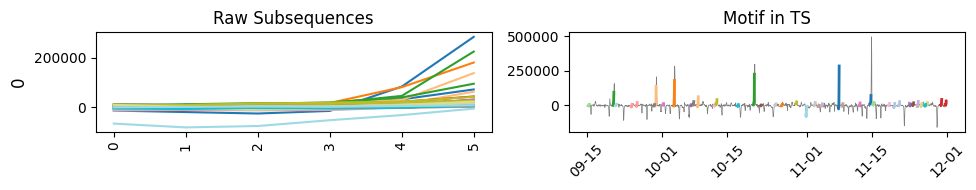

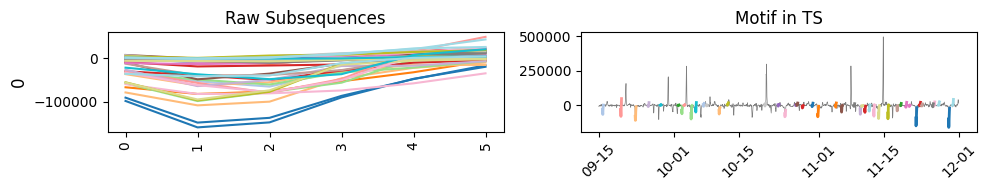

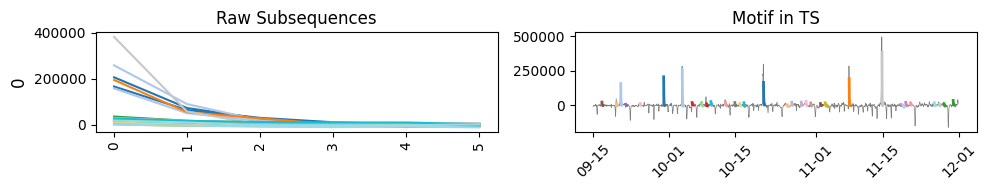

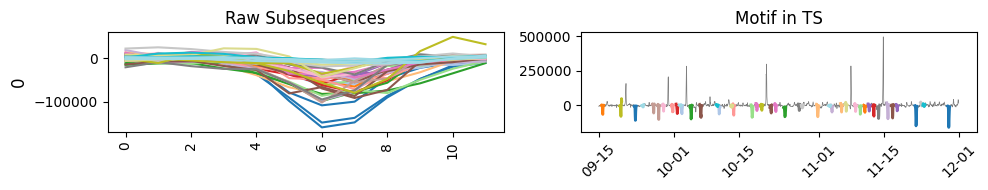

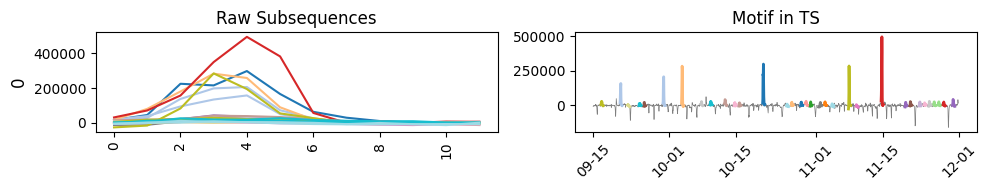

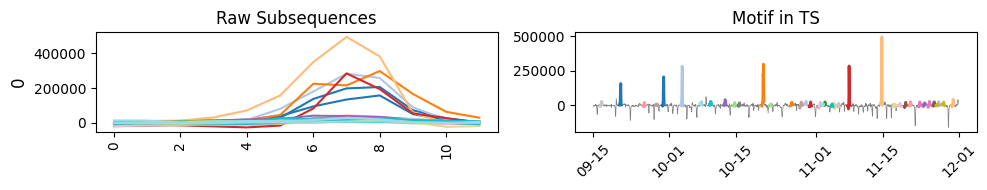

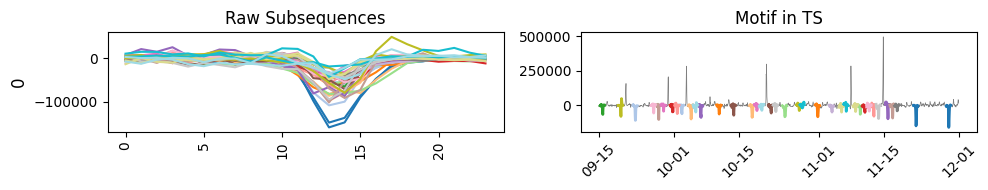

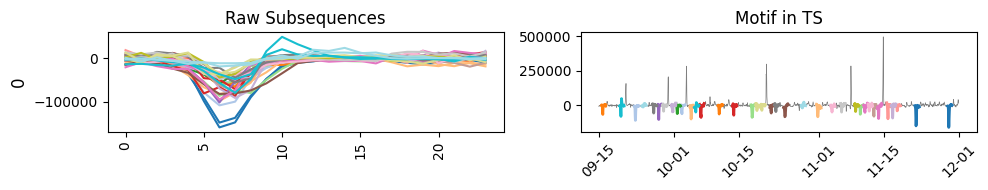

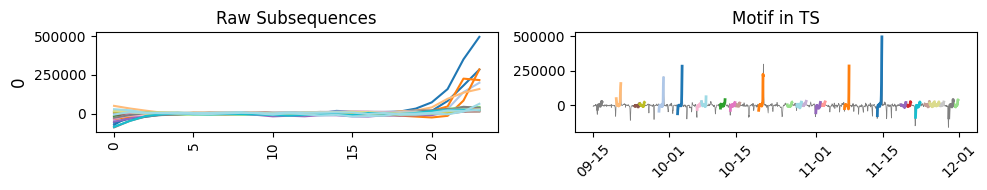

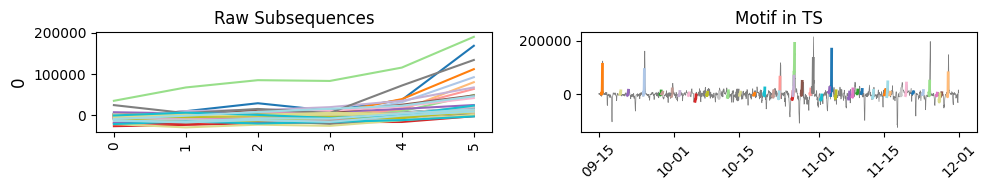

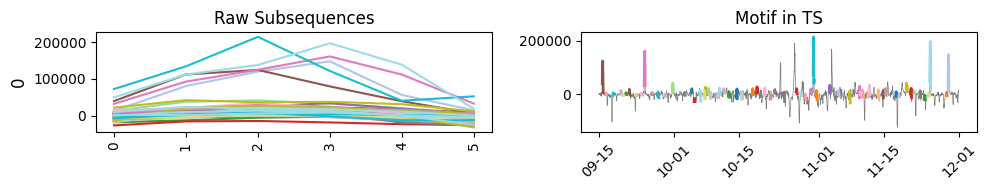

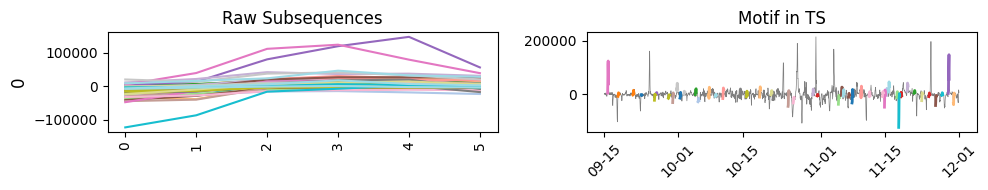

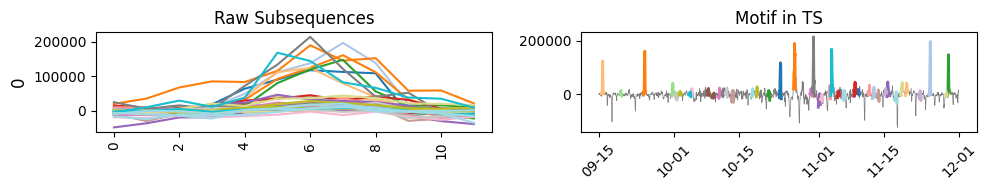

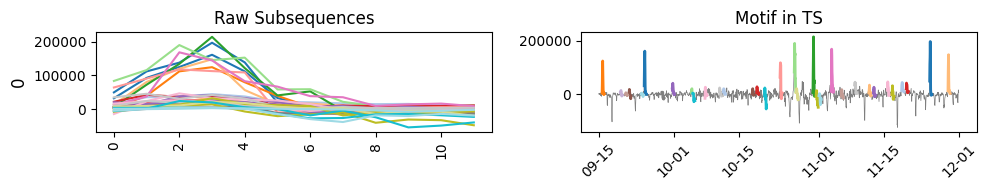

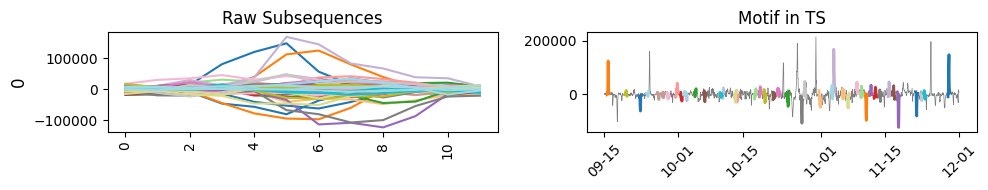

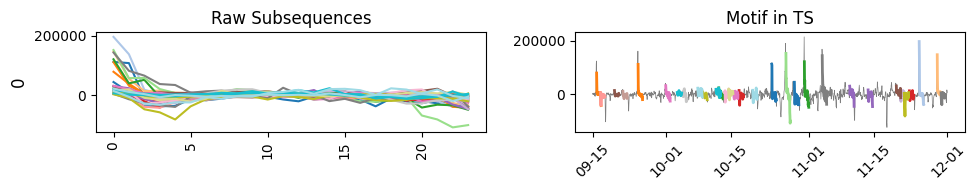

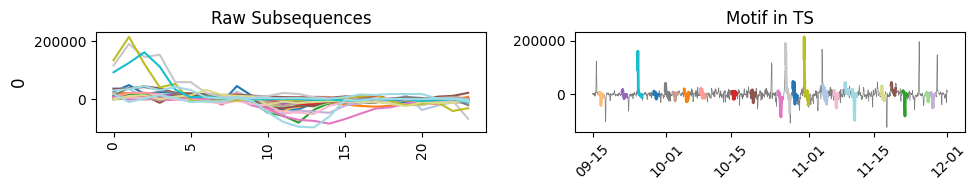

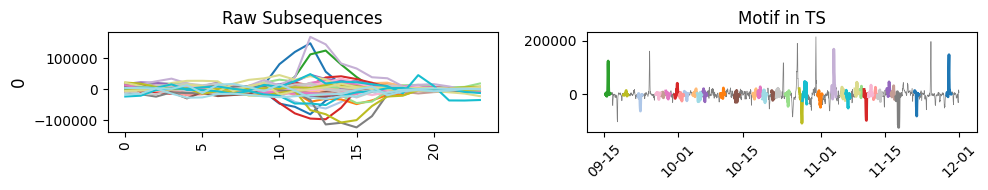

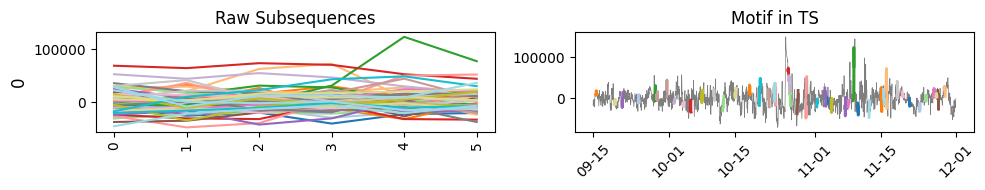

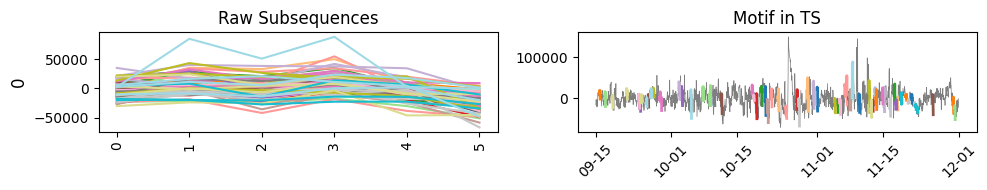

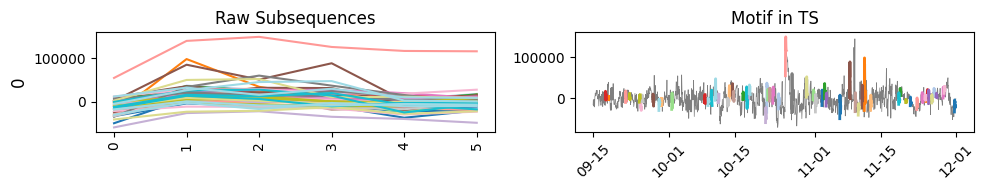

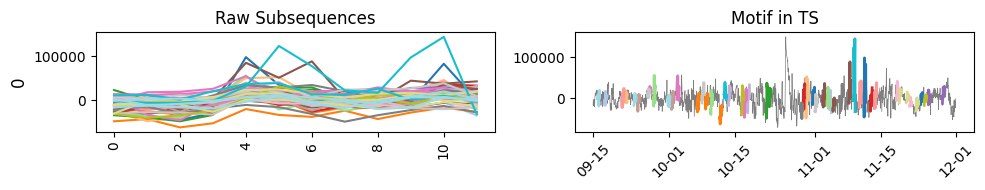

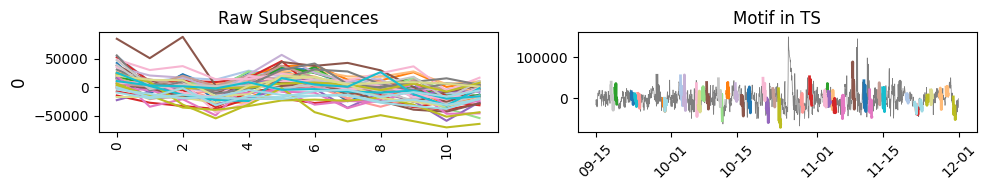

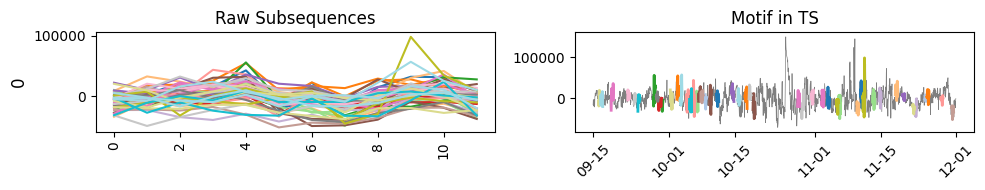

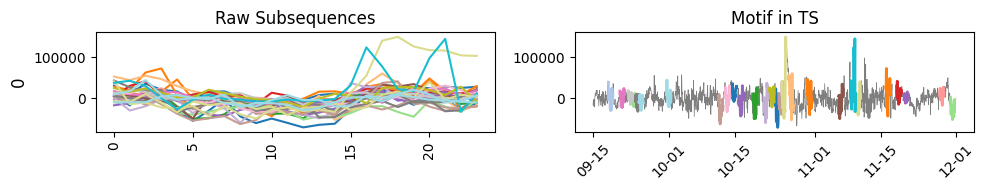

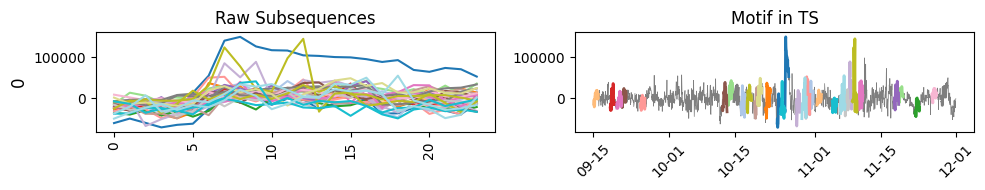

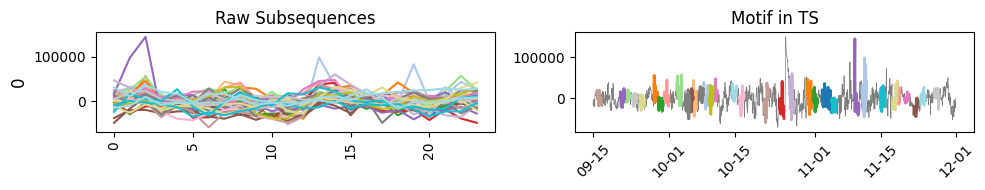

In [18]:
#plot top motif
for i, df in top_resids.groupby(by=["id","feature"]):
    mp_stats_table = pd.read_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]))
    subsequence_lengths = mp_stats_table["m"].unique()
    data = pd.DataFrame(df['residuals'].values, index=df['index'])
    data.index = pd.to_datetime(data.index)
    #data to dataframe
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="p-value").head(3)
        for top_motif in top_motifs.to_dict(orient="records"): 
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i[0])+"_"+str(i[1])+"_"+str(top_motif["ID"])
            ts_list = [data]
            plot_motif(ts_list, features, m, indices, motif_name)